#### Goal

Feature Selection:  build features for a play-level model that evaluates the potential a play call (e.g. pass, rush, field goal, etc)  based on the situation and team stats

 - The independent values consist of situations such as drive, down, yards to go seconds reaminign in the game, etc.

- The dependent or "Y" features are simply whether the game was won or lost = WIN/LOSS

- The goal is just to identify the indicators that we'll want to use for subsequent models - this is not an end in itself



#### Input

- nfl_ml_weekly_stats.parquet

#### Steps:

- Extract performance data

- convert ints to float

- measure correlation against the WIN/LOSS target

- Classify important features from XGBoost

- Classify weights from a shallow neural net

- review that they are all in agreement and pick the best from each analysis

- Use SHAP to get the relative weights (importance) for each feature

- Manually separate stats that are offense-related and those that are defence related - for any given drive the offense and defense flip. and we want to be able to provide the stats for whichever team is on offense vs the stats for the opposing team

- take the weighted average of each feature * its weights from SHAP - sum them all up to get a

- this produces a **power_scores** dataset with single offense_power score and defense_power score for each team, for each season and week

- query a version of the **play_actions** table from the database that we'll use to input for a play calling model

- merge the **power_scores** and **play_actions** datasets, so we have the correct offense and defense 'powers' scored for each play, depending on which team is offense and defense.

#### Output

- pbp_actions.parquet
- defense_power.parquet
- offense_power.parquet


<div style="background-color: teal; padding: 10px;">
    <h3 style="color: white;">imports</h3>
</div>

In [1]:
import os
import sys

sys.path.append(os.path.abspath("../src"))

In [2]:
import numpy as np
from matplotlib import pyplot as plt

import warnings

warnings.filterwarnings('ignore')


In [3]:
from src import *

<div style="background-color: teal; padding: 10px;">
    <h3 style="color: white;">setup</h3>
</div>

In [4]:
DEBUG = False
SCHEMA = 'controls'

# plt.style.use('ggplot')
plt.style.use('seaborn-darkgrid')


<div style="background-color: teal; padding: 10px;">
    <h3 style="color: white;">load weekly game stats</h3>
</div>

In [5]:
file_name = get_config('game_stats')
data_directory = get_config('data_directory')
input_path = os.path.join(data_directory, f"{file_name}.parquet")
assert os.path.exists(input_path)

weekly_stats_df = pd.read_parquet(input_path)
stats_df = weekly_stats_df.copy()

<div style="background-color: teal; padding: 10px;">
    <h3 style="color: white;">prepare data</h3>
</div>

### <font color="#9370DB">split into train and test sets</font>
Use 2016 through 2011 seasons to predict the 2022 season

In [6]:

from sklearn.preprocessing import MinMaxScaler

def scale_numeric_columns(df):
    scaler = MinMaxScaler()
    features = scaler.fit_transform(df.to_numpy())
    X = pd.DataFrame(features, columns=df.columns)
    return X

drop_columns = [ 'season', 'week', 'game_id', 'home_team', 'away_team', 'home_final_score' , 'away_final_score']

game_train = stats_df.loc[stats_df['season'] < 2022]
game_test = stats_df.loc[stats_df['season'] == 2022]

X_train = game_train.drop(columns=drop_columns)
y_train = X_train.pop('loss_tie_win')
X_test = game_test.drop(columns=drop_columns)
y_test = X_test.pop('loss_tie_win')

X_train = scale_numeric_columns(X_train)
X_test = scale_numeric_columns(X_test)




<div style="background-color: teal; padding: 10px;">
    <h3 style="color: white;">create and execute the team-week win/loss models</h3>
</div>

In [7]:
from src.models.team_week_model import create_team_week_model, train_team_week_model

model = create_team_week_model(
    X_train.shape[1],
    regularization_rate=.001,
    activation_function="relu",
    output_function="sigmoid")

r = train_team_week_model(model=model, X=X_train, y=y_train,
                               epochs_size=500,
                               batch_size=32,
                               verbose=0,
                               learning_rate=.001,
                               validation_split=0.25,
                               # validation_data=(X_test, y_test),
                               loss_function='binary_crossentropy')


2023-07-25 12:36:03.483065: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2023-07-25 12:36:03.483086: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2023-07-25 12:36:03.483089: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2023-07-25 12:36:03.483151: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-07-25 12:36:03.483323: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2023-07-25 12:36:03.936508: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-07-25 12:36:04.509022:

<div style="background-color: teal; padding: 10px;">
    <h3 style="color: white;">review model performnce</h3>
</div>

### <font color="#9370DB">plot loss</font>

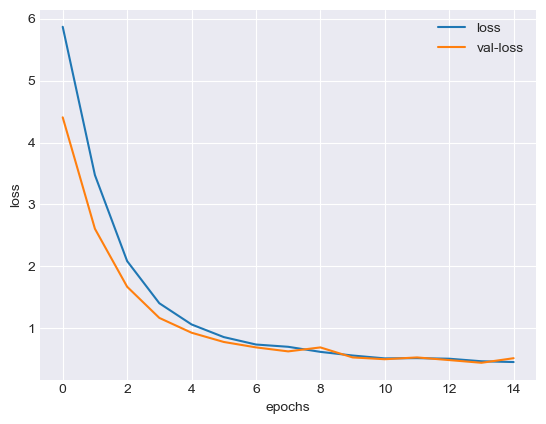

In [8]:

from src.util.utils_eda import plot_loss

plot_loss(r)

### <font color="#9370DB">plot accuracy</font>

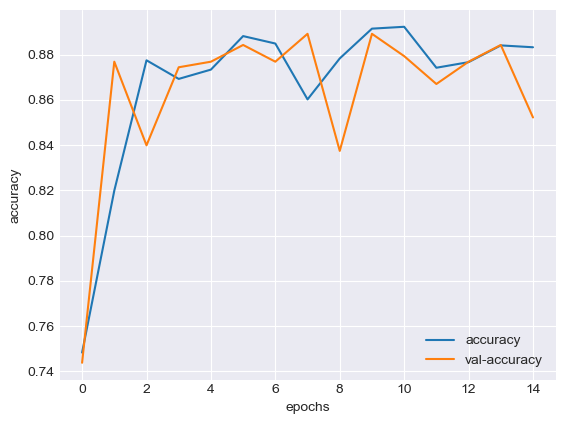

In [9]:
from src.util.utils_eda import plot_accuracy

plot_accuracy(r)

<div style="background-color: teal; padding: 10px;">
    <h3 style="color: white;">explain results</h3>
</div>

2023-07-25 12:36:10.754409: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


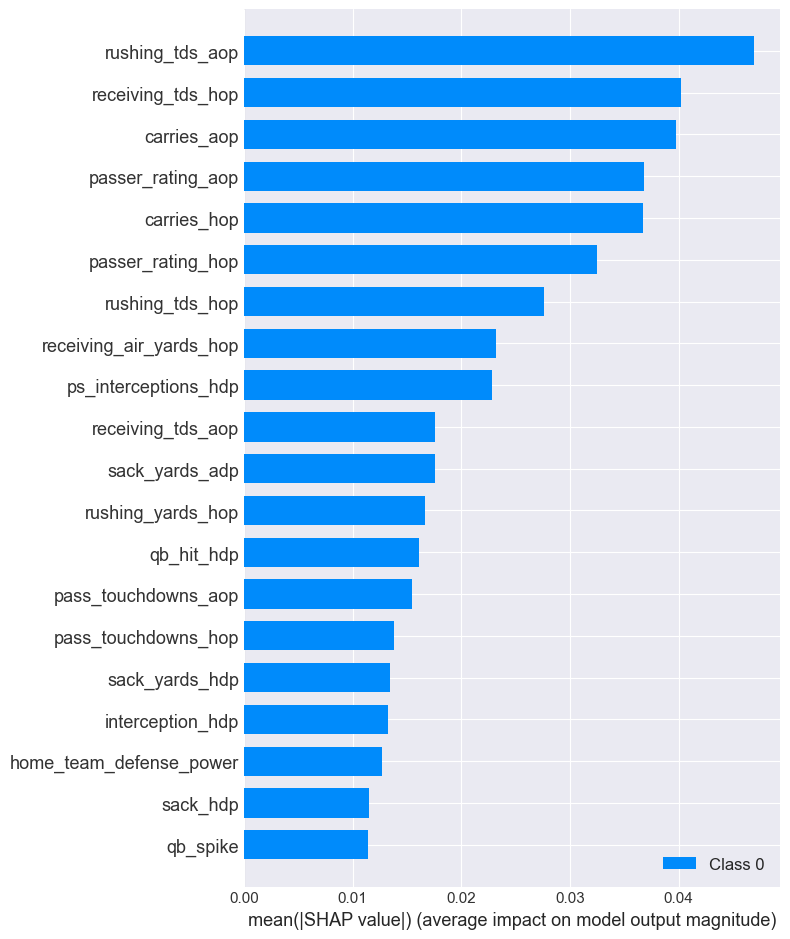

In [10]:
import shap

# Assuming you have a trained Keras model 'model' and a dataset 'X'
explainer = shap.DeepExplainer(model, data=X_train.values)
shap_values = explainer.shap_values(X_train.values)

# save off the explanation so we can review later
game_train_with_shap = pd.concat([game_train['game_id'], pd.DataFrame(shap_values[0], columns=X_train.columns)], axis=1)

# Calculate the mean absolute SHAP values and standard deviations
summary_data = pd.DataFrame({
    'Feature': X_train.columns,
    'Mean': np.abs(shap_values[0]).mean(axis=0)  # Corrected this line to use shap_values[0] directly
})

# Plotting the SHAP values with column names
shap.summary_plot(shap_values, X_train, feature_names=X_train.columns)

<div style="background-color: teal; padding: 10px;">
    <h3 style="color: white;">evaluate performance</h3>
</div>

### <font color="#9370DB">precision, recall, f1, auc</font>

In [11]:

threshold = 0.5
y_pred_probs = model.predict(X_test)
y_pred_binary = (y_pred_probs >= threshold).astype(int)
count = np.sum(y_pred_probs > 0.5)
print('Count of positive predictions: ', count)

game_test['y_pred_binary'] = y_pred_binary

9/9 [==============================] - 0s 3ms/step
Count of positive predictions:  166


2023-07-25 12:36:20.934654: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


In [12]:
# save off the predictions so we can review them
game_test['y_pred_binary'] = y_pred_binary

In [13]:
from src.util.utils_eda import print_f1_scores
from sklearn.metrics import roc_auc_score

print_f1_scores(y_pred_binary, y_test)



Precision: 0.8614457831325302
Recall: 0.8827160493827161
F1-score: 0.8719512195121952


### <font color="#9370DB">ROC /AUC score</font>

AUC:     0.8470957296093907


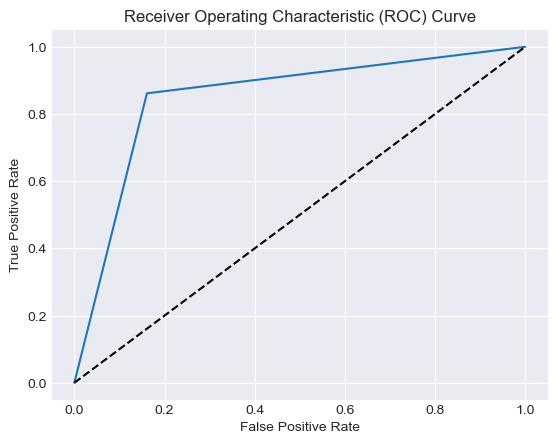

In [14]:
from src.util.util_keras import plot_roc_curve

# Assuming you have y_actual and y_predicted for binary classification
auc = roc_auc_score(y_test, y_pred_binary)
print("AUC:    ", auc)
plot_roc_curve(y_pred_binary, y_test)

### <font color="#9370DB">confusion matrix</font>

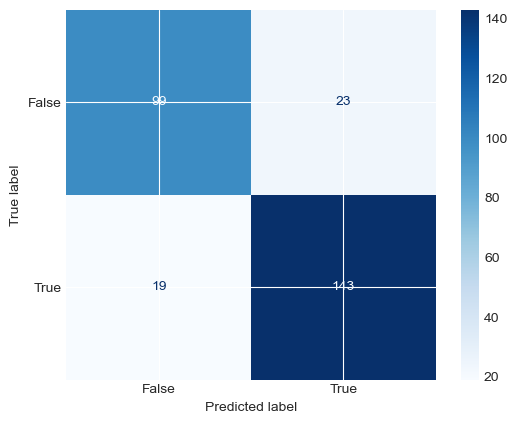

In [15]:
from src.util.utils_eda import plot_confusion_matrix

plot_confusion_matrix(y_pred_binary, y_test)

Save test predictions

### <font color="#9370DB">review predictions</font>

In [26]:

# Save test predictions
game_test['point_difference'] = abs(game_test['home_final_score'] - game_test['away_final_score'])
game_test['predicted'] = game_test['y_pred_binary'].apply(lambda x: 'loss' if x == 0 else 'win/tie')
game_test['model_win_loss'] = game_test.apply( lambda row: 'loss' if row['loss_tie_win'] == 0 else 'win/tie' if row['home_final_score'] == row['away_final_score']  else 'win', axis=1)
game_test['actual'] = game_test.apply(lambda row: 'win' if row['home_final_score'] > row['away_final_score'] else 'loss' if row['home_final_score'] < row['away_final_score'] else 'tie', axis=1)
game_test['status'] = game_test.apply(lambda row: 'prediction_error' if row['y_pred_binary'] != row['loss_tie_win'] else 'correct_prediction', axis=1)

game_test['confusion'] = game_test.apply(lambda row:
                                         'misclassified-loss' if row['status'] == 'prediction_error' and row['loss_tie_win'] == 0
                                         else 'misclassified-win' if row['status'] == 'prediction_error' and row['loss_tie_win'] == 1
                                         else 'predicted-loss' if row['status'] == 'correct_prediction' and row['loss_tie_win'] == 0
                                         else 'predicted-win' if row['status'] == 'correct_prediction' and row['loss_tie_win'] == 1
                                         else 'error', axis=1)


* We can see that the model misclassified 23 losses as wins and 19 wins as losses - close to what we saw in the confusion matrix

In [27]:
game_test.groupby(['confusion']).agg(predictions=('status', 'count'))


,predictions
confusion,
misclassified-loss,23
misclassified-win,19
predicted-loss,99
predicted-win,143


Reviewing the mis-classified games
- we can see that the errors are spread across teams - there is no one team that is consistently mis-classified
- and they are evenly spread across the whole 2022 season - there's no particular week that is worse than others
- 67% of the point differences are between 0 and 3 points - so the model is having trouble with close games
- but the other 33% point differences are between 4 and 7 - with one 10 point spread - so it's not just close games

Next steps
- The stats and predictions and shap scores for all errors are in the game_test and game_train tables - we can review them to see if there are any patterns we can use to tweak the model
- We can also use the same data to speculate whether some additional data or even statistics (e.g. wp, ep, etc.) would have helped the model
-

In [30]:
game_test.loc[game_test['status'] == 'prediction_error', ['game_id', 'home_team', 'away_team', 'home_final_score', 'away_final_score', 'point_difference', 'predicted',  'actual', 'status', 'confusion']].sort_values(by=['point_difference'], ascending=True)

,game_id,home_team,away_team,home_final_score,away_final_score,point_difference,predicted,actual,status,confusion
1627,2022_01_IND_HOU,HOU,IND,20,20,0,loss,tie,prediction_error,misclassified-win
1895,2022_19_LAC_JAX,JAX,LAC,31,30,1,loss,win,prediction_error,misclassified-win
1787,2022_12_BAL_JAX,JAX,BAL,28,27,1,loss,win,prediction_error,misclassified-win
1794,2022_12_LAC_ARI,ARI,LAC,24,25,1,win/tie,loss,prediction_error,misclassified-loss
1804,2022_13_DEN_BAL,BAL,DEN,10,9,1,loss,win,prediction_error,misclassified-win
1811,2022_13_NO_TB,TB,NO,17,16,1,loss,win,prediction_error,misclassified-win
1823,2022_14_LV_LA,LA,LV,17,16,1,loss,win,prediction_error,misclassified-win
1649,2022_02_NYJ_CLE,CLE,NYJ,30,31,1,win/tie,loss,prediction_error,misclassified-loss
1883,2022_18_HOU_IND,IND,HOU,31,32,1,win/tie,loss,prediction_error,misclassified-loss
1632,2022_01_NO_ATL,ATL,NO,26,27,1,win/tie,loss,prediction_error,misclassified-loss


<div style="background-color: teal; padding: 10px;">
    <h3 style="color: white;">save model</h3>
</div>

In [16]:
model_directory = get_config('model_directory')
full_path = os.path.join(model_directory, 'team_week_model.keras')
model.save(full_path)

<div style="background-color: teal; padding: 10px;">
    <h3 style="color: white;">save predictions</h3>
</div>

In [ ]:
%%time
db = DatabaseLoader(get_config('connection_string'))
db.load_table(df=game_test, table_name='exp2_game_predictions',schema=get_config('database_schema'))
db.load_table(df=game_train, table_name='exp2_shap_scores',schema=get_config('database_schema'))
